In [15]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pickle
import mediapipe as mp

In [22]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

def load_image(image_path):
    img=cv2.imread(image_path)
    img=cv2.resize(img,(480,480))
    image, results = mediapipe_detection(img, holistic)
    keypoints = extract_keypoints(results)
    return keypoints

model=load_model('model01.keras')


# 1. New detection variables
sequence = []
predictions = []
label=int(input("Enter the label number: "))
person_id=int(input("Enter Your id number: "))

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        
        frame=cv2.resize(frame,(480,480))
        
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-90:]
        
        if len(sequence) == 90:
            sequence=[sequence[int(j)] for j in np.arange(0,89,3)]
            sequence=np.array(sequence)
            np.save(f'New_Data\\{label}\\{person_id}.npy',sequence)
            break
            
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [16]:
with open('New_class.pkl', 'rb') as file:
    classes = pickle.load(file)

In [18]:
classes[9]

'<start> DO NOT WORRY <end>'

In [ ]:
import os

# Define the range of directory names (0 to 210)
directory_names = range(98)

# Specify the parent directory where you want to create these subdirectories
parent_directory = "New_Data"

# Create directories
for directory_name in directory_names:
    # Join the parent directory path with the directory name
    directory_path = os.path.join(parent_directory, str(directory_name))
    
    # Check if the directory already exists, and create it if not
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

print("Directories created successfully.")

In [31]:
import os
import numpy as np

# Set the root directory where your data folders are located
root_directory = "New_Data"

# Initialize empty lists to store data and labels
X = []
y = []

# Loop through each folder in the root directory
for class_folder in os.listdir(root_directory):
    class_folder_path = os.path.join(root_directory, class_folder)

    # Check if the path is a directory
    if os.path.isdir(class_folder_path):
        # Loop through each .npy file in the folder
        for file_name in os.listdir(class_folder_path):
            file_path = os.path.join(class_folder_path, file_name)

            # Check if the file is a .npy file
            if file_name.endswith(".npy"):
                # Load the data from the .npy file
                data = np.load(file_path)

                # Append data to X and corresponding label to y
                X.append(data)
                y.append(int(class_folder))

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (165, 30, 258)
Shape of y: (165,)


In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [55]:
y = to_categorical(y).astype(int)

In [56]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [126]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def create_sign_language_model(input_shape, num_classes):
    model = models.Sequential()

    # Conv1D layer for temporal feature extraction
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # LSTM layer for temporal sequence processing
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(0.5))

    # Flatten before passing to Dense layers
    model.add(layers.Flatten())

    # Dense layers with dropout for classification
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Set the input shape based on your data (e.g., sequence_length, input_dim)
input_shape = (30, 258)  # Adjust based on your video frame size and channels
num_classes = 11  # Number of classes for sign language

# Create the model
model = create_sign_language_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [127]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=115, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/1000


4/4 [==============================] - 6s 595ms/step - loss: 9.8315 - accuracy: 0.1238 - val_loss: 9.3755 - val_accuracy: 0.0370
Epoch 2/1000
4/4 [==============================] - 0s 56ms/step - loss: 9.1887 - accuracy: 0.0857 - val_loss: 8.8021 - val_accuracy: 0.0370
Epoch 3/1000
4/4 [==============================] - 0s 64ms/step - loss: 8.6504 - accuracy: 0.0857 - val_loss: 8.2847 - val_accuracy: 0.0370
Epoch 4/1000
4/4 [==============================] - 0s 70ms/step - loss: 8.1113 - accuracy: 0.0667 - val_loss: 7.8555 - val_accuracy: 0.0000e+00
Epoch 5/1000
4/4 [==============================] - 0s 58ms/step - loss: 7.6913 - accuracy: 0.0952 - val_loss: 7.4612 - val_accuracy: 0.0000e+00
Epoch 6/1000
4/4 [==============================] - 0s 56ms/step - loss: 7.2453 - accuracy: 0.1619 - val_loss: 7.1149 - val_accuracy: 0.0741
Epoch 7/1000
4/4 [==============================] - 0s 66ms/step - loss: 6.9147 - accuracy: 0.0762 - val_loss: 6.7547 - val_accuracy: 0.0370
Epoch 8/1000
4/4 

In [129]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


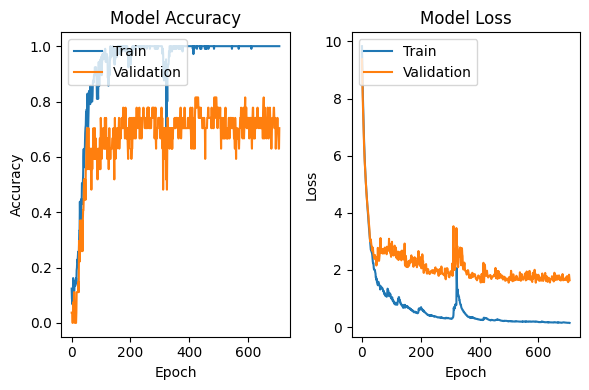

In [130]:
plot_training_history(history)

In [131]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 6ms/step - loss: 1.6623 - accuracy: 0.6364


[1.6622925996780396, 0.6363636255264282]

In [145]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def create_updated_model(input_shape, num_classes):
    model = models.Sequential()

    # Conv1D layer for temporal feature extraction
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))

    # LSTM layer for temporal sequence processing
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(0.2))

    # Conv1D layer for additional feature extraction
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))

    # Flatten before passing to Dense layers
    model.add(layers.Flatten())

    # Dense layers with dropout for classification
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    # Output layer with 11 units for classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Set the updated input shape and output classes
input_shape = (30, 258)
num_classes = 11

# Create the updated model
model2 = create_updated_model(input_shape, num_classes)

# Compile the updated model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the updated model
model2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 28, 128)           99200     
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 14, 128)          0         
 g1D)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 14, 128)           131584    
                                                                 
 dropout_55 (Dropout)        (None, 14, 128)           0         
                                                                 
 conv1d_29 (Conv1D)          (None, 12, 128)           49280     
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 6, 128)           0         
 g1D)                                                

In [146]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with early stopping
history2 = model2.fit(X_train, y_train, epochs=1000, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/1000
4/4 [==============================] - 5s 341ms/step - loss: 7.8387 - accuracy: 0.1048 - val_loss: 7.5004 - val_accuracy: 0.1111
Epoch 2/1000
4/4 [==============================] - 0s 49ms/step - loss: 7.3552 - accuracy: 0.0952 - val_loss: 7.0971 - val_accuracy: 0.1111
Epoch 3/1000
4/4 [==============================] - 0s 54ms/step - loss: 6.9567 - accuracy: 0.0857 - val_loss: 6.7567 - val_accuracy: 0.0000e+00
Epoch 4/1000
4/4 [==============================] - 0s 61ms/step - loss: 6.5637 - accuracy: 0.1429 - val_loss: 6.4225 - val_accuracy: 0.0000e+00
Epoch 5/1000
4/4 [==============================] - 0s 64ms/step - loss: 6.2499 - accuracy: 0.0667 - val_loss: 6.0672 - val_accuracy: 0.0370
Epoch 6/1000
4/4 [==============================] - 0s 64ms/step - loss: 5.9207 - accuracy: 0.1048 - val_loss: 5.7585 - val_accuracy: 0.0741
Epoch 7/1000
4/4 [==============================] - 0s 63ms/step - loss: 5.6232 - accuracy: 0.1333 - val_loss: 5.5012 - val_accuracy: 0.0000e+00


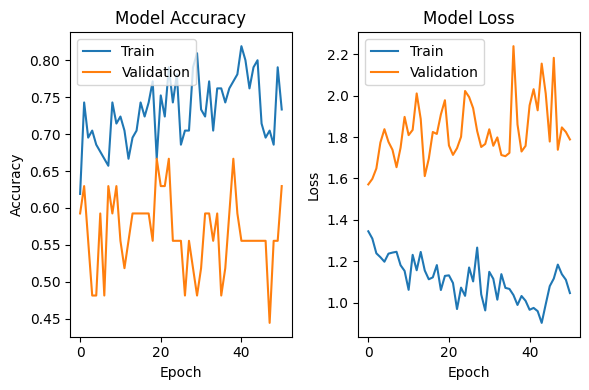

In [141]:
plot_training_history(history2)

In [151]:
model2.evaluate(X_test,y_test)

2/2 [==============================] - 0s 8ms/step - loss: 1.8602 - accuracy: 0.6061


[1.860152244567871, 0.6060606241226196]

In [152]:
model2.save('new_model1.keras')